In [6]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from ml_wireless_classification.base.ANR import AdaptiveNoiseReduction

from ml_wireless_classification.base.SignalUtils import (
    compute_instantaneous_features, compute_modulation_index, compute_spectral_asymmetry,
    instantaneous_frequency_deviation, spectral_entropy, envelope_mean_variance,
    spectral_flatness, spectral_peaks_bandwidth, zero_crossing_rate, compute_fft_features,
    autocorrelation, is_digital_signal, compute_kurtosis, compute_skewness,
    compute_spectral_energy_concentration, compute_instantaneous_frequency_jitter,
    compute_spectral_kurtosis, compute_higher_order_cumulants, compute_crest_factor,
    compute_spectral_entropy, compute_energy_spread, compute_autocorrelation_decay,
    compute_rms_of_instantaneous_frequency, compute_entropy_of_instantaneous_frequency,
    compute_envelope_variance, compute_papr
)
from scipy.fftpack import fft, ifft
from scipy.signal import convolve, welch
from scipy.signal.windows import gaussian  # Import Gaussian from windows module


import numpy as np
from scipy.signal import welch

def calculate_psd(signal, fs=1.0):
    """
    Calculate the Power Spectral Density (PSD) using Welch's method.
    This will be used to estimate the power across different frequency bands.
    
    Parameters:
    - signal (array-like): The input signal
    - fs (float): Sampling frequency
    
    Returns:
    - f (array): Frequency bins
    - Pxx (array): Power Spectral Density values
    """
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    return f, Pxx

def low_frequency_energy(f, Pxx, low_cutoff=0.0, high_cutoff=0.2):
    """
    Calculate the energy in the low frequency band.
    
    Parameters:
    - f (array): Frequency bins
    - Pxx (array): Power Spectral Density values
    - low_cutoff (float): Low frequency cutoff
    - high_cutoff (float): High frequency cutoff for the low band
    
    Returns:
    - low_energy (float): Low frequency energy concentration
    """
    mask = (f >= low_cutoff) & (f < high_cutoff)
    low_energy = np.sum(Pxx[mask]) / np.sum(Pxx)
    return low_energy

def mid_frequency_energy(f, Pxx, low_cutoff=0.2, high_cutoff=0.5):
    """
    Calculate the energy in the mid frequency band.
    
    Parameters:
    - f (array): Frequency bins
    - Pxx (array): Power Spectral Density values
    - low_cutoff (float): Low frequency cutoff for the mid band
    - high_cutoff (float): High frequency cutoff for the mid band
    
    Returns:
    - mid_energy (float): Mid frequency energy concentration
    """
    mask = (f >= low_cutoff) & (f < high_cutoff)
    mid_energy = np.sum(Pxx[mask]) / np.sum(Pxx)
    return mid_energy

def high_frequency_energy(f, Pxx, low_cutoff=0.5):
    """
    Calculate the energy in the high frequency band.
    
    Parameters:
    - f (array): Frequency bins
    - Pxx (array): Power Spectral Density values
    - low_cutoff (float): Low frequency cutoff for the high band
    
    Returns:
    - high_energy (float): High frequency energy concentration
    """
    mask = f >= low_cutoff
    high_energy = np.sum(Pxx[mask]) / np.sum(Pxx)
    return high_energy

# Additional helper functions
def frequency_convolution(signal, kernel):
    """Apply convolution in the frequency domain using a specific kernel."""
    return np.real(ifft(fft(signal) * fft(kernel, len(signal))))

def high_frequency_ratio(signal, cutoff=0.5):
    """Calculate the high-frequency power ratio above a normalized cutoff frequency (0-1 scale)."""
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    high_freq_power = np.sum(np.abs(fft_values[np.abs(freqs) > cutoff])**2)
    total_power = np.sum(np.abs(fft_values)**2)
    return high_freq_power / total_power if total_power > 0 else 0

# Additional feature extraction functions
def symbol_power_variance(signal):
    """Calculate the variance of the symbol power, focusing on the consistency of symbol strength."""
    return np.var(np.abs(signal)**2)

def symbol_distribution_entropy(signal):
    """Calculate the entropy of the symbol distribution."""
    hist, _ = np.histogram(np.angle(signal), bins=64, density=True)
    hist = hist[hist > 0]  # Exclude zero entries for entropy calculation
    return -np.sum(hist * np.log2(hist))

def signal_density(signal, threshold=0.1):
    """Calculate density of symbols above a certain power threshold."""
    power = np.abs(signal)**2
    return np.mean(power > threshold)

def spectral_energy_concentration(signal, center_freq=0.5):
    """Calculate spectral energy concentration around a center frequency."""
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal))
    center_energy = np.sum(np.abs(fft_values[(freqs > center_freq - 0.1) & (freqs < center_freq + 0.1)])**2)
    total_energy = np.sum(np.abs(fft_values)**2)
    return center_energy / total_energy if total_energy > 0 else 0

# Add new features
def extract_additional_qam_features(complex_signal, real_part):
    # Symbol and amplitude-based features
    add_feature("Symbol Power Variance", symbol_power_variance, complex_signal)
    add_feature("Symbol Distribution Entropy", symbol_distribution_entropy, complex_signal)
    add_feature("Signal Density (0.1 Threshold)", signal_density, complex_signal)
    add_feature("Spectral Energy Concentration", spectral_energy_concentration, complex_signal)
    add_feature("Inst. Freq. Dev", instantaneous_frequency_deviation, complex_signal)
    add_feature("Spectral Entropy", spectral_entropy, real_part)
    add_feature("Envelope Mean", lambda x: envelope_mean_variance(x)[0], real_part)
    add_feature("Envelope Variance", lambda x: envelope_mean_variance(x)[1], real_part)
    add_feature("Spectral Flatness", spectral_flatness, real_part)
    add_feature("Spectral Peaks", lambda x: spectral_peaks_bandwidth(x)[0], real_part)
    add_feature("Bandwidth", lambda x: spectral_peaks_bandwidth(x)[1], real_part)
    add_feature("Zero Crossing Rate", zero_crossing_rate, real_part)
    add_feature("Amplitude Mean", lambda x: np.mean(compute_instantaneous_features(x)[0]), real_part)
    add_feature("Phase Variance", lambda x: np.var(compute_instantaneous_features(x)[1]), real_part)
    add_feature("Modulation Index", compute_modulation_index, real_part)
    add_feature("Spectral Sparsity", compute_spectral_asymmetry, real_part)
    add_feature("Envelope Ratio", lambda x: envelope_mean_variance(x)[0] / (envelope_mean_variance(x)[1] + 1e-10), real_part)
    add_feature("FFT Center Freq", lambda x: compute_fft_features(x)[0], real_part)
    add_feature("FFT Peak Power", lambda x: compute_fft_features(x)[1], real_part)
    add_feature("FFT Avg Power", lambda x: compute_fft_features(x)[2], real_part)
    add_feature("FFT Std Dev Power", lambda x: compute_fft_features(x)[3], real_part)
    add_feature("Kurtosis", compute_kurtosis, real_part)
    add_feature("Skewness", compute_skewness, real_part)
    add_feature("HOC-2", lambda x: compute_higher_order_cumulants(x, order=2), real_part)
    add_feature("HOC-3", lambda x: compute_higher_order_cumulants(x, order=3), real_part)
    add_feature("HOC-4", lambda x: compute_higher_order_cumulants(x, order=4), real_part)
    add_feature("Crest Factor", compute_crest_factor, real_part)
    add_feature("Spectral Entropy Value", compute_spectral_entropy, real_part)
    add_feature("Autocorr Decay", compute_autocorrelation_decay, real_part)
    add_feature("RMS Instant Freq", compute_rms_of_instantaneous_frequency, real_part)
    add_feature("Entropy Instant Freq", compute_entropy_of_instantaneous_frequency, real_part)
    add_feature("Envelope Variance", compute_envelope_variance, real_part)
    add_feature("PAPR", compute_papr, real_part)
    add_feature("Avg Symbol Power", lambda x: np.mean(np.abs(x)**2), complex_signal)
    add_feature("Magnitude Variance", lambda x: np.var(np.abs(x)), complex_signal)
    add_feature("PAPR", lambda x: np.max(np.abs(x)**2) / np.mean(np.abs(x)**2), complex_signal)
    add_feature("Kurtosis Magnitude", lambda x: compute_kurtosis(np.abs(x)), complex_signal)
    add_feature("Skewness Magnitude", lambda x: compute_skewness(np.abs(x)), complex_signal)


# Global dictionary to store feature names and values
feature_dict = {}

def add_feature(name, func, *args):
    """Try to add a feature by checking the shape and ensuring it’s a scalar."""
    try:
        value = func(*args)
        # If value is an array, check if it is scalar (single value)
        if np.isscalar(value) or (isinstance(value, np.ndarray) and value.size == 1):
            feature_dict[name] = value.item() if isinstance(value, np.ndarray) else value
        else:
            print(f"Warning: Feature '{name}' has incorrect shape and was not added.")
    except Exception as e:
        print(f"Error computing feature '{name}': {e}")

def extract_features(data):
    features = []
    labels = []
    anr = AdaptiveNoiseReduction(threshold=0.05, method="gaussian")

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]
            complex_signal = real_part + 1j * imag_part

            # Apply ANR to IQ data
            iq_data = np.vstack((real_part, imag_part)).T
            if snr < 5:
                real_denoised = anr.apply(torch.tensor(real_part).float())
                imag_denoised = anr.apply(torch.tensor(imag_part).float())
                
                real_part = real_denoised
                imag_part = imag_denoised
            
            complex_signal = real_part + 1j * imag_part

            # Reset feature dictionary for each signal
            global feature_dict
            feature_dict = {}

            # # Apply additional QAM-specific features
            extract_additional_qam_features(complex_signal, real_part)

            # Compute PSD
            f, Pxx = calculate_psd(complex_signal)
            # other featues in test 
            add_feature("Low Frequency Energy Concentration", low_frequency_energy, f, Pxx, 0.0, 0.05)
            add_feature("Mid Frequency Energy Concentration", mid_frequency_energy, f, Pxx, 0.05, 0.2)
            add_feature("High Frequency Energy Concentration", high_frequency_energy, f, Pxx, 0.5)


            # Add SNR as a feature
            feature_dict["SNR"] = snr  # Include SNR as part of the features

            # Append the feature values and label
            features.append(list(feature_dict.values()))
            labels.append(mod_type)

    return np.array(features), labels

# Load the RML2016.10a_dict.pkl file with explicit encoding
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")


# Feature extraction with ANR applied
features, labels = extract_features(data)

# Encode labels for classification
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=42)




/home/dev/python/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/dev/workspace/ML-wireless-signal-classification/src/ml_wireless_classification/base/SignalUtils.py:175: RuntimeWarning: invalid value encountered in log
  
/home/dev/python/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1024 is greater than input length  = 128, using nperseg = 128
  warnings.warn('nperseg = {0:d} is greater than input length '
/home/dev/python/lib/python3.8/site-packages/scipy/signal/_spectral_py.py:1867: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [7]:



def clean_training_data(X, y):
    """
    Cleans X and y by ensuring that all elements are scalars and removing infinities.
    Prints a message if a sequence (list, tuple, array) or non-numeric value is found.
    """
    def check_and_clean_array(arr, array_name):
        cleaned_arr = []
        for i, row in enumerate(arr):
            cleaned_row = []
            for j, value in enumerate(row):
                # Check if value is scalar
                if np.isscalar(value):
                    # Check for infinities or non-finite values
                    if np.isinf(value) or np.isnan(value) or value > np.finfo(np.float32).max:
                        # print(f"Warning: {array_name}[{i}][{j}] has an infinity or too large value. Setting to 0.")
                        cleaned_row.append(0)  # Replace infinities or overly large values with 0
                    else:
                        cleaned_row.append(value)
                elif isinstance(value, (list, tuple, np.ndarray)):
                    # If it's a sequence, take the first element as a workaround (optional)
                    sub_value = value[0] if len(value) > 0 else 0
                    if np.isinf(sub_value) or np.isnan(sub_value) or sub_value > np.finfo(np.float32).max:
                        # print(f"Warning: {array_name}[{i}][{j}] contains infinity or too large in sequence. Setting to 0.")
                        sub_value = 0
                    cleaned_row.append(sub_value)
                    # print(f"Warning: {array_name}[{i}][{j}] is a sequence. Taking the first element.")
                elif isinstance(value, str):
                    # Handle string values with a warning
                    # print(f"Warning: {array_name}[{i}][{j}] is a string. Removing and setting to 0.")
                    cleaned_row.append(0)
                else:
                    # print(f"Warning: Unexpected data type at {array_name}[{i}][{j}]: {type(value)}")
                    cleaned_row.append(0)  # Default to 0 if type is unexpected
            cleaned_arr.append(cleaned_row)
        
        # Ensure cleaned_arr is a 2D array of fixed-length rows
        max_length = max(len(row) for row in cleaned_arr)
        # Pad rows with zeros if they are shorter than max_length
        cleaned_arr = [row + [0] * (max_length - len(row)) for row in cleaned_arr]
        
        return np.array(cleaned_arr, dtype=float)
    
    # Clean X and y
    X_cleaned = check_and_clean_array(X, "X_train")
    y_cleaned = np.array([elem if np.isscalar(elem) else elem[0] for elem in y], dtype=float)

    return X_cleaned, y_cleaned

def ensure_2d(arr, name):
    """
    Ensures the array is 2D by reshaping if necessary.
    """
    if arr.ndim == 1:
        print(f"Warning: {name} is 1-dimensional. Reshaping to 2D.")
        arr = arr.reshape(-1, 1)
    return arr

# Clean training and test data
X_train, y_train = clean_training_data(X_train, y_train)
X_test, y_test = clean_training_data(X_test, y_test)

# Ensure both X_train and X_test are 2D arrays
X_train = ensure_2d(X_train, "X_train")
X_test = ensure_2d(X_test, "X_test")


SNR: -20.0 dB, Accuracy: 8.60%
SNR: -18.0 dB, Accuracy: 10.80%
SNR: -16.0 dB, Accuracy: 12.15%
SNR: -14.0 dB, Accuracy: 19.45%
SNR: -12.0 dB, Accuracy: 24.16%
SNR: -10.0 dB, Accuracy: 34.72%
SNR: -8.0 dB, Accuracy: 46.51%
SNR: -6.0 dB, Accuracy: 59.91%
SNR: -4.0 dB, Accuracy: 67.87%
SNR: -2.0 dB, Accuracy: 74.13%
SNR: 0.0 dB, Accuracy: 80.11%
SNR: 2.0 dB, Accuracy: 81.27%
SNR: 4.0 dB, Accuracy: 83.02%
SNR: 6.0 dB, Accuracy: 83.27%
SNR: 8.0 dB, Accuracy: 84.17%
SNR: 10.0 dB, Accuracy: 84.84%
SNR: 12.0 dB, Accuracy: 85.42%
SNR: 14.0 dB, Accuracy: 85.83%
SNR: 16.0 dB, Accuracy: 83.73%
SNR: 18.0 dB, Accuracy: 85.36%


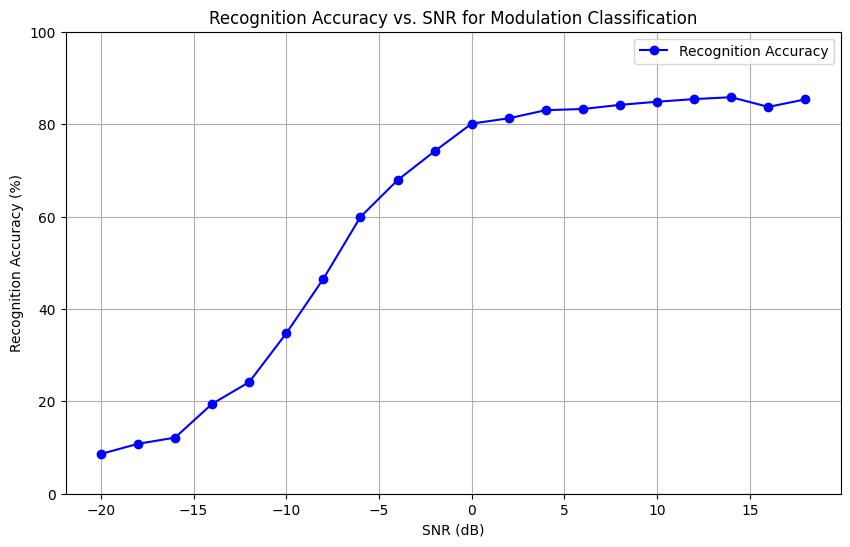

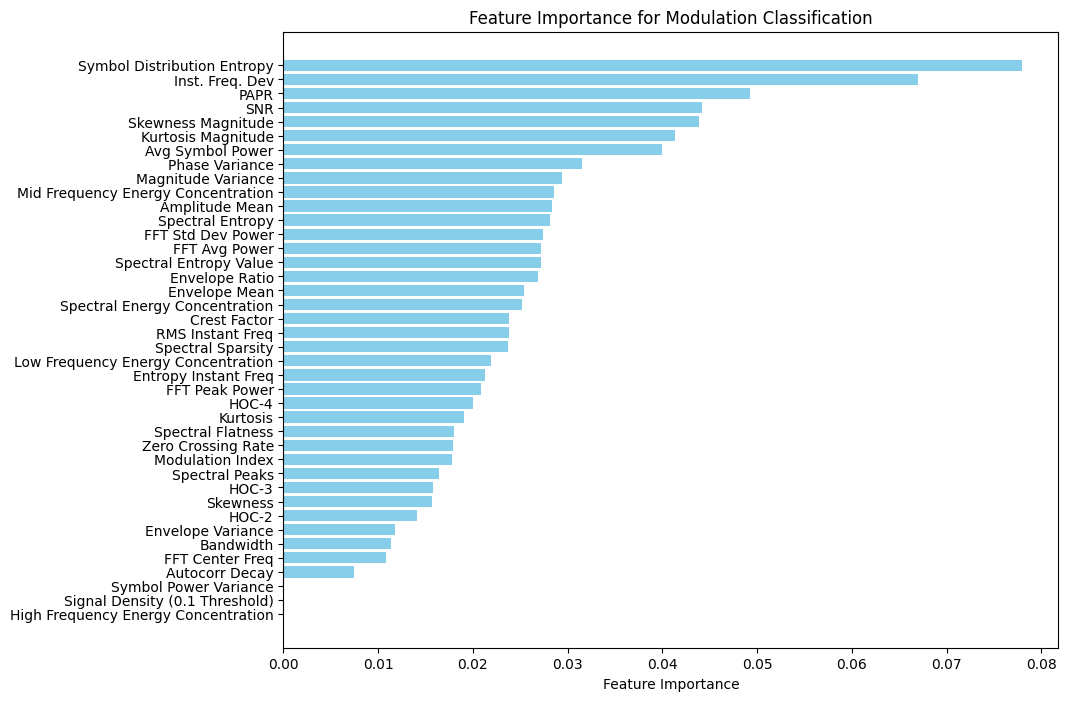

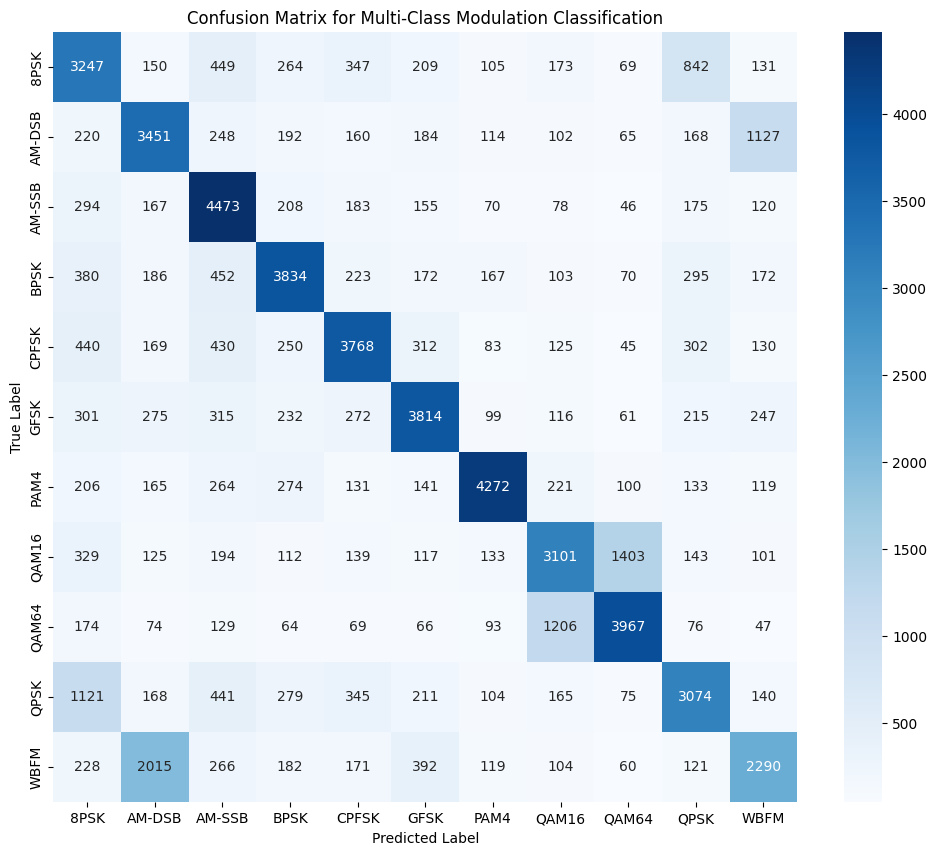

Classification Report for Modulation Types:
              precision    recall  f1-score   support

        8PSK       0.47      0.54      0.50      5986
      AM-DSB       0.50      0.57      0.53      6031
      AM-SSB       0.58      0.75      0.66      5969
        BPSK       0.65      0.63      0.64      6054
       CPFSK       0.65      0.62      0.64      6054
        GFSK       0.66      0.64      0.65      5947
        PAM4       0.80      0.71      0.75      6026
       QAM16       0.56      0.53      0.54      5897
       QAM64       0.67      0.67      0.67      5965
        QPSK       0.55      0.50      0.53      6123
        WBFM       0.50      0.39      0.43      5948

    accuracy                           0.60     66000
   macro avg       0.60      0.60      0.59     66000
weighted avg       0.60      0.60      0.59     66000



In [8]:


# Train a single classifier on the entire dataset for multi-class classification
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate accuracy for each SNR level
unique_snrs = sorted(set(X_test[:, -1]))  # Get unique SNR levels from test set
accuracy_per_snr = []

for snr in unique_snrs:
    # Select samples with the current SNR
    snr_indices = np.where(X_test[:, -1] == snr)
    X_snr = X_test[snr_indices]
    y_snr = y_test[snr_indices]

    # Predict and calculate accuracy
    y_pred = clf.predict(X_snr)
    accuracy = accuracy_score(y_snr, y_pred)
    accuracy_per_snr.append(accuracy * 100)  # Convert to percentage

    print(f"SNR: {snr} dB, Accuracy: {accuracy * 100:.2f}%")

# Plot Recognition Accuracy vs. SNR
plt.figure(figsize=(10, 6))
plt.plot(unique_snrs, accuracy_per_snr, 'b-o', label='Recognition Accuracy')
plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Recognition Accuracy vs. SNR for Modulation Classification")
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()

# Feature importance for the classifier
feature_names = list(feature_dict.keys())
importances = clf.feature_importances_
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot sorted feature importances
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Modulation Classification")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.show()

# Confusion matrix for overall test set
y_pred_test = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Multi-Class Modulation Classification")
plt.show()

# Print Classification Report
print("Classification Report for Modulation Types:")
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))
